<a href="https://colab.research.google.com/github/elikuj/PHYS498-MLP/blob/main/PHYS_498_Homework_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 01: Introduction to Data Science

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import numpy as np
import pandas as pd
import os.path
import subprocess
from sklearn import cluster, decomposition

Helpers for Getting, Loading and Locating Data

In [2]:
def wget_data(url: str):
    local_path = './tmp_data'
    p = subprocess.Popen(["wget", "-nc", "-P", local_path, url], stderr=subprocess.PIPE, encoding='UTF-8')
    rc = None
    while rc is None:
      line = p.stderr.readline().strip('\n')
      if len(line) > 0:
        print(line)
      rc = p.poll()

def locate_data(name, check_exists=True):
    local_path='./tmp_data'
    path = os.path.join(local_path, name)
    if check_exists and not os.path.exists(path):
        raise RuxntimeError('No such data file: {}'.format(path))
    return path

## <span style="color:Orange">Problem 1</span>

Use `np.einsum` to evaluate the tensor expression $g^{il} \Gamma^m_{ki} x^k$ which arises in [contravariant derivatives in General Relativity](https://en.wikipedia.org/wiki/Christoffel_symbols#Covariant_derivatives_of_tensors).  Note we are using the GR convention that repeated indices (k,l) are summed over.

In [3]:
def tensor_expr(g, Gamma, x, D=4):
    """Evaluate the tensor expression above.

    Parameters
    ----------
    g : array
        Numpy array of shape (D, D)
    Gamma : array
        Numpy array of shape (D, D, D)
    x : array
        Numpy array of shape (D,)
    D : int
        Dimension of input tensors.

    Returns
    -------
    array
        Numpy array of shape (D, D) that evaluates the tensor expression.
    """
    assert g.shape == (D, D)
    assert Gamma.shape == (D, D, D)
    assert x.shape == (D,)

    return np.einsum("il,mki,k->lm", g, Gamma, x)

    raise NotImplementedError()

In [4]:
# A correct solution should pass these tests.
g = np.arange(4 ** 2).reshape(4, 4)
Gamma = np.arange(4 ** 3).reshape(4, 4, 4)
x = np.arange(4)
y = tensor_expr(g, Gamma, x)
assert np.array_equal(
    y,
    [[ 1680,  3984,  6288,  8592], [ 1940,  4628,  7316, 10004],
     [ 2200,  5272,  8344, 11416], [ 2460,  5916,  9372, 12828]])

## <span style="color:Orange">Problem 2</span>

The normal (aka Gaussian) distribution is one of the fundamental probability densities that we will encounter often.

Implement the function below using `np.random.multivariate_normal` to generate random samples from an arbitrary multidimensional normal distribution, for a specified random seed:

In [5]:
def generate_normal(mu, C, n, seed=123):
    """Generate random samples from a normal distribution.

    Parameters
    ----------
    mu : array
        1D array of mean values of length N.
    C : array
        2D array of covariances of shape (N, N). Must be a positive-definite matrix.
    n : int
        Number of random samples to generate.
    seed : int
        Random number seed to use.

    Returns
    -------
    array
        2D array of shape (n, N) where each row is a random N-dimensional sample.
    """
    assert len(mu.shape) == 1, 'mu must be 1D.'
    assert C.shape == (len(mu), len(mu)), 'C must be N x N.'
    assert np.all(np.linalg.eigvals(C) > 0), 'C must be positive definite.'

    np.random.seed(seed)
    return np.random.multivariate_normal(mu, C, n)

    raise NotImplementedError()

In [6]:
# A correct solution should pass these tests.
mu = np.array([-1., 0., +1.])
C = np.identity(3)
C[0, 1] = C[1, 0] = -0.9
Xa = generate_normal(mu, C, n=500, seed=1)
Xb = generate_normal(mu, C, n=500, seed=1)
Xc = generate_normal(mu, C, n=500, seed=2)
assert np.array_equal(Xa, Xb)
assert not np.array_equal(Xb, Xc)
X = generate_normal(mu, C, n=2000, seed=3)
assert np.allclose(np.mean(X, axis=0), mu, rtol=0.001, atol=0.1)
assert np.allclose(np.cov(X, rowvar=False), C, rtol=0.001, atol=0.1)

Visualize a generated 3D dataset using:

In [7]:
def visualize_3d():
    mu = np.array([-1., 0., +1.])
    C = np.identity(3)
    C[0, 1] = C[1, 0] = -0.9
    X = generate_normal(mu, C, n=2000, seed=3)
    df = pd.DataFrame(X, columns=('x0', 'x1', 'x2'))
    sns.pairplot(df)

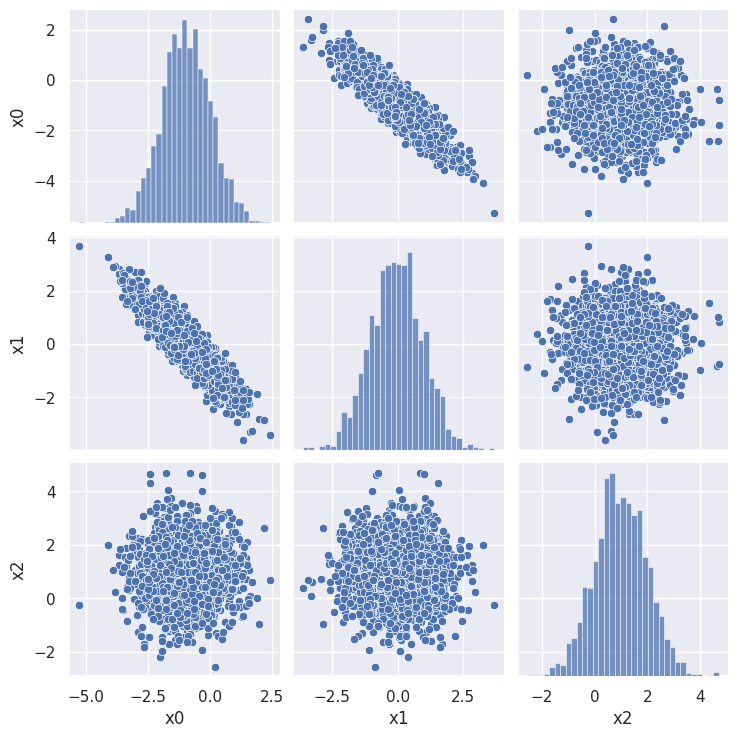

In [8]:
visualize_3d()

Read about [correlation and covariance](https://en.wikipedia.org/wiki/Covariance_and_correlation), then implement the function below to create a 2x2 covariance matrix given values of $\sigma_x$, $\sigma_y$ and the correlation coefficient $\rho$:

In [9]:
def create_2d_covariance(sigma_x, sigma_y, rho):
    """Create and return the 2x2 covariance matrix specified by the input args.
    """
    assert (sigma_x > 0) and (sigma_y > 0), 'sigmas must be > 0.'
    # YOUR CODE HERE
    cov = np.zeros((2,2))
    cov[0,0] = sigma_x**2
    cov[1,0] = rho*(sigma_x * sigma_y)
    cov[0,1] = cov[1,0]
    cov[1,1] = sigma_y**2

    return cov

In [10]:
# A correct solution should pass these tests.
assert np.array_equal(create_2d_covariance(1., 1.,  0.0), [[1.,  0.], [ 0., 1.]])
assert np.array_equal(create_2d_covariance(2., 1.,  0.0), [[4.,  0.], [ 0., 1.]])
assert np.array_equal(create_2d_covariance(2., 1.,  0.5), [[4.,  1.], [ 1., 1.]])
assert np.array_equal(create_2d_covariance(2., 1., -0.5), [[4., -1.], [-1., 1.]])

Run the following cell that uses your `create_2d_covariance` and `generate_normal` functions to compare the 2D normal distributions with $\rho = 0$ (blue), $\rho = +0.9$ (red) and $\rho = -0.9$ (green):

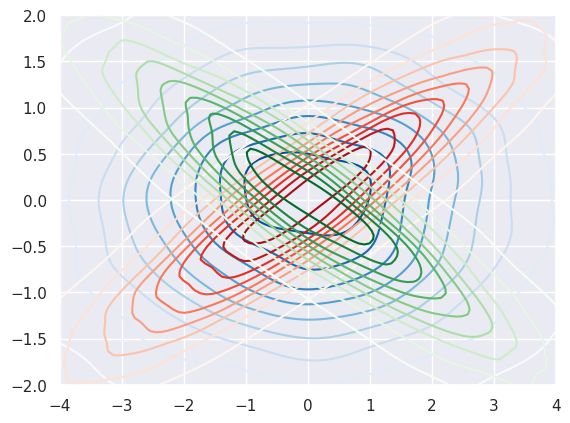

In [11]:
def compare_rhos():
    mu = np.zeros(2)
    sigma_x, sigma_y = 2., 1.
    for rho, cmap in zip((0., +0.9, -0.9), ('Blues', 'Reds', 'Greens')):
        C = create_2d_covariance(sigma_x, sigma_y, rho)
        X = generate_normal(mu, C, 10000)
        sns.kdeplot(x=X[:, 0], y=X[:, 1], cmap=cmap)
    plt.xlim(-4, +4)
    plt.ylim(-2, +2)

compare_rhos()

## <span style="color:Orange">Problem 3</span>

The [Expectation-Maximization (EM) algorithm](https://en.wikipedia.org/wiki/Expectation-maximization_algorithm) is used to implement many machine learning methods, including several we have already studied like K-means and soon to be studied (e.g. factor analysis and weighted PCA.)

The basic idea of EM is to optimize a goal function that depends on two disjoint sets of parameters by alternately updating one set and then the other, using a scheme that is guaranteed to improve the goal function (although generally to a local rather than global optimum). The alternating updates are called the E-step and M-step.

The K-means is one of the simplest uses of EM, so is a good way to get some hands-on experience.

Implement the function below to perform a K-means E-step. Hint: you might find [np.linalg.norm](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html) and [np.argmin](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.argmin.html) useful.

In [12]:
def E_step(X, centers):
    """Perform a K-means E-step.

    Assign each sample to the cluster with the nearest center, using the
    Euclidean norm to measure distance between a sample and a cluster center.

    Parameters
    ----------
    X : array with shape (N, D)
        Input data consisting of N samples in D dimensions.
    centers : array with shape (n, D)
        Centers of the the n clusters in D dimensions.

    Returns
    -------
    integer array with shape (N,)
        Cluster index of each sample, in the range 0 to n-1.
    """
    N, D = X.shape
    n = len(centers)
    assert centers.shape[1] == D
    indices = np.empty(N, int)

    for i in range(0, N):
      indices[i] = np.argmin([np.linalg.norm(X[i] - j) for j in centers])

    return indices

In [13]:
# A correct solution should pass these tests.
gen = np.random.RandomState(seed=123)
X = gen.normal(size=(100, 2))
centers = np.array([[0., 0.], [0., 10.]])
X[50:] += centers[1]
indices = E_step(X, centers)
assert np.all(indices[:50] == 0)
assert np.all(indices[50:] == 1)

gen = np.random.RandomState(seed=123)
X = gen.normal(size=(20, 2))
centers = gen.uniform(size=(5, 2))
indices = E_step(X, centers)
assert np.array_equal(indices, [4, 1, 4, 4, 1, 0, 1, 0, 2, 1, 2, 4, 0, 1, 0, 1, 0, 1, 4, 4])

Next, implement the function below to perform a K-means M-step:

In [14]:
def M_step(X, indices, n):
    """Perform a K-means M-step.

    Calculate the center of each cluster as the geometric mean of its assigned samples.

    The centers of any clusters without any assigned samples should be set to the origin.

    Parameters
    ----------
    X : array with shape (N, D)
        Input data consisting of N samples in D dimensions.
    indices : integer array with shape (N,)
        Cluster index of each sample, in the range 0 to n-1.
    n : int
        Number of clusters.  Must be <= N.

    Returns
    -------
    array with shape (n, D)
        Centers of the the n clusters in D dimensions.
    """
    N, D = X.shape
    assert indices.shape == (N,)
    assert n <= N
    centers = np.zeros((n, D))
    # YOUR CODE HERE
    for i in range(n):
        numwcent = 0
        for j in range(N):
            if(indices[j]==i):
                numwcent+=1
                centers[i]+=X[j]
        if numwcent != 0:
            centers[i] = centers[i]*1.0/numwcent


    return centers

In [15]:
# A correct solution should pass these tests.
gen = np.random.RandomState(seed=123)
X = np.ones((20, 2))
indices = np.zeros(20, int)
centers = M_step(X, indices, 1)
assert np.all(centers == 1.)

n = 5
indices = gen.randint(n, size=len(X))
centers = M_step(X, indices, n)
assert np.all(centers == 1.)

X = gen.uniform(size=X.shape)
centers = M_step(X, indices, n)
assert np.allclose(
    np.round(centers, 3),
    [[ 0.494,  0.381], [ 0.592,  0.645],
     [ 0.571,  0.371], [ 0.234,  0.634],
     [ 0.250,  0.386]])

You have now implemented the core of the K-means algorithm.  Try it out with this simple wrapper, which makes a scatter plot of the first two columns after each iteration. The sklearn wrapper combines the result of several random starting points and has other refinements.

In [16]:
def KMeans_fit(data, n_clusters, nsteps, seed=123):
    X = data.values
    N, D = X.shape
    assert n_clusters <= N
    gen = np.random.RandomState(seed=seed)
    # Pick random samples as the initial centers.
    shuffle = gen.permutation(N)
    centers = X[shuffle[:n_clusters]]
    # Perform an initial E step to assign samples to clusters.
    indices = E_step(X, centers)
    # Loop over iterations.
    for i in range(nsteps):
        centers = M_step(X, indices, n_clusters)
        indices = E_step(X, centers)
    # Plot the result.
    cmap = np.array(sns.color_palette())
    plt.scatter(X[:, 0], X[:, 1], c=cmap[indices % len(cmap)])
    plt.scatter(centers[:, 0], centers[:, 1], marker='+', c='k', s=400, lw=5)
    plt.show()

Try it out on some randomly generated 2D data with 3 separate clusters (using the handy [make_blobs](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html)):

In [17]:
from sklearn.datasets import make_blobs
gen = np.random.RandomState(seed=123)
X, _ = make_blobs(n_samples=500, n_features=2, centers=[[-3,-3],[0,3],[3,-3]], random_state=gen)
data = pd.DataFrame(X, columns=('x0', 'x1'))

For this simple test, you should find a good solution after two iterations:

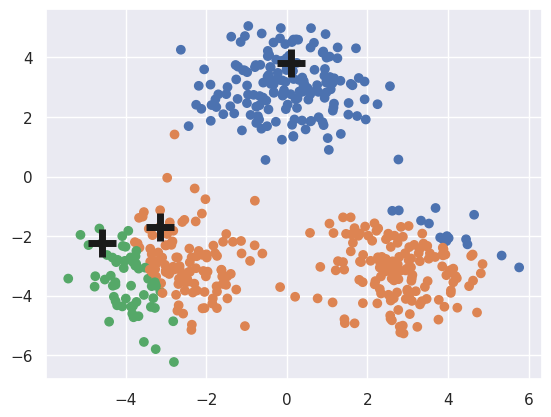

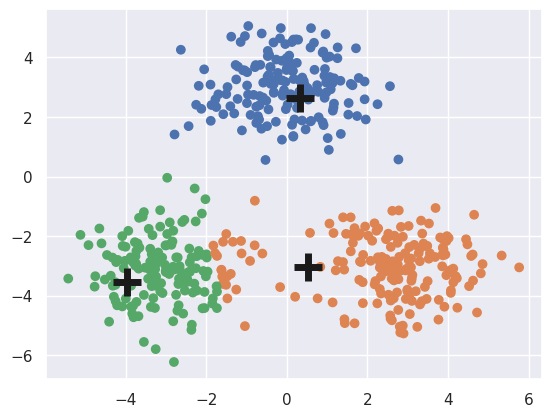

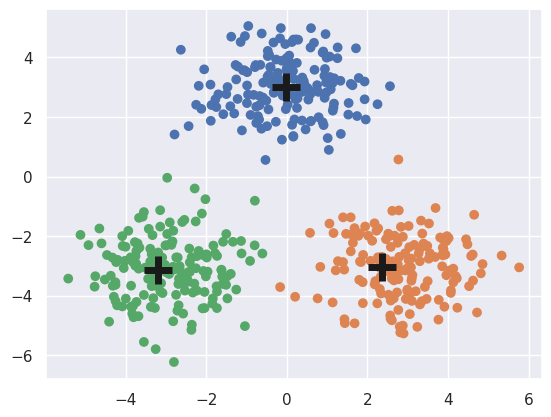

In [18]:
KMeans_fit(data, n_clusters=3, nsteps=0);
KMeans_fit(data, n_clusters=3, nsteps=1);
KMeans_fit(data, n_clusters=3, nsteps=2);

## <span style="color:Orange">Problem 4</span>

In [19]:
from sklearn import cluster, decomposition

In [20]:
wget_data('https://raw.githubusercontent.com/illinois-mlp/MachineLearningForPhysics/main/data/spectra_data.hf5')

--2025-01-29 05:04:49--  https://raw.githubusercontent.com/illinois-mlp/MachineLearningForPhysics/main/data/spectra_data.hf5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 414744 (405K) [application/octet-stream]
Saving to: ‘./tmp_data/spectra_data.hf5’
     0K .......... .......... .......... .......... .......... 12% 2.35M 0s
    50K .......... .......... .......... .......... .......... 24% 13.0M 0s
   100K .......... .......... .......... .......... .......... 37% 6.06M 0s
   150K .......... .......... .......... .......... .......... 49% 20.4M 0s
   200K .......... .......... .......... .......... .......... 61% 26.2M 0s
   250K .......... .......... .......... .......... .......... 74% 7.79M 0s
   300K .......... .......... .......... .......... .....

In [21]:
spectra_data = pd.read_hdf(locate_data('spectra_data.hf5'))

The PCA method of dimensionality reduction first calculates an exact linear decomposition (up to round off error),
then trims rows and columns to the desired number of latent variables.  In this problem, you will explore how PCA is implemented. The tricky linear algebra is already implemented in [numpy.linalg](https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.linalg.html), but it is still a challenge to keep all the notation and conventions self consistent.

The input data $X$ is provided as an $N\times D$ (samples, features) matrix. In the following we assume that each feature is centered on zero (otherwise, calculate and subtract the $\mu_j$, then add them back later),
$$
\mu_j = \sum_i X_{ij} = 0 \;.
$$
There are three equivalent methods for performing the initial exact decomposition:

1. Calculate the $D\times D$ [sample covariance matrix](https://en.wikipedia.org/wiki/Sample_mean_and_covariance#Sample_covariance)
$$
C \equiv \frac{1}{N-1}\,X^T X \;.
$$
then find its eigenvalue decomposition:
$$
C = Q^T \Lambda Q
$$
where $\Lambda$ is a diagonal $D\times D$ matrix of eigenvalues and the rows of the orthogonal $D\times D$ matrix $Q$ are the corresponding eigenvectors.

2. Calculate the $N\times N$ matrix of dot products between samples:
$$
D \equiv \frac{1}{N-1}\,X X^T \;,
$$
then find its eigenvalue decomposition, where now $Q$ and $\Lambda$ are $N\times N$ matrices.

3. Find the [singular value decomposition (SVD)](https://en.wikipedia.org/wiki/Singular-value_decomposition) of $X$
$$
X = U S V \quad \Rightarrow \quad C = \frac{1}{N-1}\,V^T S^2 V \;,
$$
where $S$ is a diagonal $K\times K$ matrix of *singular values*, $U$ is $N\times K$ and $V$ is $K\times D$, with
$K = \min(N, D)$. The notation above is chosen to match [np.linalg.svd](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.linalg.svd.html) which you will use below.

The computational cost of each method depends differently on the values of $N$ and $D$, so the most efficient method will depend on the shape of the input data $X$. There are also numerical considerations: the matrices $C$ and $D$ should be [positive definite](https://en.wikipedia.org/wiki/Positive-definite_matrix) in order to guarantee positive eigenvalues, but this will not be true for $C$ if $N < D$ or for $D$ if $N > D$.

Implement the function below to calculate the eigenvectors and eigenvalues of a square input matrix using a suitable function from [np.linalg](https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.linalg.html).  The results should be sorted in order of decreasing eigenvalues, as needed by PCA. Hint: `M[::-1]` reverses the rows of a 2D array `M` (more info [here](https://docs.scipy.org/doc/numpy-dev/user/quickstart.html#indexing-slicing-and-iterating)).

In [22]:
def eigensolve(M):
    """Calculate eigenvectors and eigenvalues of a square symmetric matrix.

    Results are sorted by decreasing eigenvalue. The rows (not columns) of the
    returned eigenvector array are the normalized eigenvectors of M.

    Parameters
    ----------
    M : 2D array
        N x N symmetric square matrix to use.

    Returns
    -------
    tuple
        Tuple of arrays (eigenvalues, eigenvectors) with eigenvalues decreasing and
        eigenvector[i] corresponding to eigenvalue[i].  Eigenvalues should have the
        shape (N,) and eigenvectors should have the shape (N, N).
    """
    assert len(M.shape) == 2
    nrows, ncols = M.shape
    assert nrows == ncols
    assert np.all(M.T == M)
    # YOUR CODE HERE
    return (np.linalg.eigh(M)[0][::-1], np.linalg.eigh(M)[1].T[::-1])


In [23]:
#A function to check work
def checkEigens(evals: np.ndarray, evecs: np.ndarray, covariance: np.ndarray, knownEvals: np.ndarray, knownEvecs: np.ndarray):
    assert np.allclose(covariance, evecs.T.dot(np.diag(evals).dot(evecs)))
    assert np.allclose(
        np.round(evals, 5),
        knownEvals)
    assert np.allclose(
        np.round(np.abs(evecs), 3),
        np.abs(knownEvecs)
    )
    #Accounting for direction
    for calcRow, knownRow in zip(np.round(evecs, 3), knownEvecs):
        assert np.allclose(calcRow, knownRow) or np.allclose(-1 * calcRow, knownRow)

In [24]:
# A correct solution should pass the tests below.
C = np.diag(np.arange(1., 5.))
evals, evecs = eigensolve(C)

checkEigens(evals, evecs, C,
    knownEvals=[4, 3, 2, 1],
    knownEvecs=[[ 0.,  0.,  0.,  1.],
     [ 0.,  0.,  1.,  0.],
     [ 0.,  1.,  0.,  0.],
     [ 1.,  0.,  0.,  0.]]
)

gen = np.random.RandomState(seed=123)
N, D = 4, 3
X = gen.uniform(size=(N, D))
X -= np.mean(X, axis=0)
C = np.dot(X.T, X) / (N - 1)
evals, evecs = eigensolve(C)
checkEigens(evals, evecs, C,
    knownEvals=[ 0.08825,  0.0481 ,  0.01983],
    knownEvecs=[[-0.787, -0.477,  0.391],
     [-0.117,  0.737,  0.665],
     [-0.606,  0.478, -0.636]]
)

Implement the function below to calculate the same quantities using the [SVD method](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.linalg.svd.html) directly on $X$ instead of solving the eigenvalue problem for the sample covariance.  Hint: pay attention to the `full_matrices` parameter.

In [91]:
def svdsolve(X):
    """Calculate eigenvectors and eigenvalues of the sample covariance of X.

    Results are sorted by decreasing eigenvalue. The rows (not columns) of the
    returned eigenvector array are the normalized eigenvectors of M.

    Uses the SVD method directly on X.

    Parameters
    ----------
    X: 2D array
        N x D matrix to use.

    Returns
    -------
    tuple
        Tuple of arrays (eigenvalues, eigenvectors) with eigenvalues decreasing and
        eigenvector[i] corresponding to eigenvalue[i].  Eigenvalues should have the
        shape (K,) and eigenvectors should have the shape (K, D) with K=min(N, D).
    """
    # YOUR CODE HERE
    assert len(X.shape) == 2
    N, D = X.shape
    U, E, V = np.linalg.svd(X, full_matrices=(N<D))
    print(E)
    Etemp = E
    while(len(Etemp) < D):
      Etemp = np.append(Etemp, 0)

    S = np.diag(Etemp)
    C = 1/(N-1) * V.T @ S @ S @ V
    C = (C + C.T)/2
    print(C)
    eigvals, eigvecs = eigensolve(C)
    eigvals = eigvals[:min(N,D)]
    assert(eigvals.shape == (min(N,D),))
    assert(eigvecs.shape == (D, D))
    return (eigvals, eigvecs)

In [92]:
# A correct solution should pass the tests below.
gen = np.random.RandomState(seed=123)
N, D = 4, 3
X = gen.uniform(size=(N, D))
X -= np.mean(X, axis=0)
evals, evecs = svdsolve(X)
C = np.dot(X.T, X) / (N - 1)
# checkEigens(evals, evecs, C,
#     knownEvals= [ 0.08825,  0.0481 ,  0.01983],
#     knownEvecs= [[-0.787, -0.477,  0.391],
#      [ 0.117, -0.737, -0.665],
#      [-0.606,  0.478, -0.636]]
# )

N, D = 3, 4
X = gen.uniform(size=(N, D))
X -= np.mean(X, axis=0)
evals, evecs = svdsolve(X)
C = np.dot(X.T, X) / (N - 1)
# Works on Google Colab (Jan '25)
checkEigens(evals, evecs, C,
    knownEvals= [ 0.23688,  0.03412,  0.     ],
    knownEvecs= [[ 0.368, 0.874,  0.316, -0.041],
     [-0.752, 0.178,  0.313, -0.553],
     [-0.516, 0.422, -0.496,  0.556]]
)
# Note: I have seen some platform dependence to the numerics in the above assess. Specifically, the third row in knownEvecs gives something different on my mac and I have to use the one below for the assert to pass.
# checkEigens(evals, evecs, C,
#    knownEvals= [ 0.23688,  0.03412,  0.     ],
#    knownEvecs= [[ 0.368, 0.874,  0.316, -0.041],
#     [-0.752, 0.178,  0.313, -0.553],
#     [-0.521, 0.417, -0.472,  0.576]]
# )
# If you run into trouble like this, include the line for the grader:
#print(evals,evecs)

[0.51452992 0.37985966 0.24389929]
[[ 0.06256657  0.02326892 -0.02325202]
 [ 0.02326892  0.05079189  0.00109089]
 [-0.02325202  0.00109089  0.04281529]]
[6.88298513e-01 2.61232163e-01 8.27395667e-17]
[[ 0.05135801  0.07159781  0.01948453  0.01062003]
 [ 0.07159781  0.18189398  0.06720908 -0.01179482]
 [ 0.01948453  0.06720908  0.02693005 -0.00894878]
 [ 0.01062003 -0.01179482 -0.00894878  0.0108165 ]]


ValueError: shapes (3,3) and (4,4) not aligned: 3 (dim 1) != 4 (dim 0)

Note that the eigenvectors found by the two methods might differ by an overall sign, but both sets of eigenvectors are orthonormal, so equally valid.

The following simple driver code shows how to build a PCA fit from your functions (but the [sklearn driver](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) has a lot more options):

In [ ]:
def PCA_fit(data, n_components=2):
    X = data.values
    N, D = X.shape
    print('N,D = {},{}'.format(N, D))
    K = min(N, D)
    assert n_components <= K
    # Subtract mean value of each feature.
    mu = np.mean(X, axis=0)
    Xc = X - mu
    # Select the method based on N, D.
    if N > 2 * D:
        print('Using method 1')
        evals, M = eigensolve(np.dot(Xc.T, Xc) / (N - 1))
        assert evals.shape == (D,) and M.shape == (D, D)
    elif D > 2 * N:
        print('Using method 2')
        evals, M = eigensolve(np.dot(Xc, Xc.T) / (N - 1))
        assert evals.shape == (N,) and M.shape == (N, N)
        # Eigenvectors are now M = U.T of the SVD.  Convert to M = V.
        # Use abs(evals) since smallest values might be < 0 due to numerical errors.
        M = np.dot(np.dot(np.diag(np.abs(evals) ** -0.5), M), Xc) / np.sqrt(N - 1)
    else:
        print('Using method 3')
        evals, M = svdsolve(Xc)
        assert evals.shape == (K,) and M.shape == (K, D)
    # Calculate Y such that Xc = Y M.
    Y = np.dot(Xc, M.T)
    # Trim to latent variable subspace.
    Y = Y[:, :n_components]
    M = M[:n_components]
    # Calculate reconstructed samples.
    Xr = np.dot(Y, M) + mu
    # Plot some samples and their reconstructions.
    for i,c in zip((0, 6, 7), sns.color_palette()):
        plt.plot(X[i], '.', c=c, ms=5)
        plt.plot(Xr[i], '-', c=c)
    plt.show()

Test this driver in each regime by varying the number of features used from `spectra_data` with $N$, $D$ = 200, 500:
- $N \gg D$: method 1
- $N \ll D$: method 2
- $N \simeq D$: method 3

In [ ]:
PCA_fit(spectra_data.iloc[:, 190:230], n_components=2)

In [ ]:
PCA_fit(spectra_data, n_components=2)

In [ ]:
PCA_fit(spectra_data.iloc[:, 120:320], n_components=2)

## <span style="color:Orange">Problem 5</span>

Implement the function below to compare clusters found in a full dataset with those found in a reduced dataset (lower-dimension latent space). Use KMeans for clustering and PCA to obtained the reduced dataset.

In [97]:
def compare_clusters(data, n_clusters, n_components, seed=123):
    """Compare clusters in the full vs reduced feature space.

    Parameters
    ----------
    data : pandas DataFrame
        Dataset to analyze of shape (N, D).
    n_clusters : int
        Number of clusters to find using KMeans.
    n_components : int
        Number of dimensions of the reduced latent variable space
        to calculate using PCA.
    seed : int
        Random number seed used for reproducible KMeans and PCA.

    Returns
    -------
    tuple
        Tuple (labels1, labels2) of 1D integer arrays of length N,
        with values 0,1,...,(n_clusters-1).
    """
    gen = np.random.RandomState(seed=seed)
    # YOUR CODE HERE
    labels1 = cluster.KMeans(n_clusters=n_clusters, random_state=gen).fit(data).labels_
    pca_data = decomposition.PCA(n_components=n_components).fit_transform(data)
    labels2 = cluster.KMeans(n_clusters=n_clusters, random_state=gen).fit(pca_data).labels_

    return (labels1, labels2)

Use the code below to test your function and comment (in the last markdown cell) on how the full vs reduced clusters compare and whether there is an advantage to clustering in reduced dimensions.

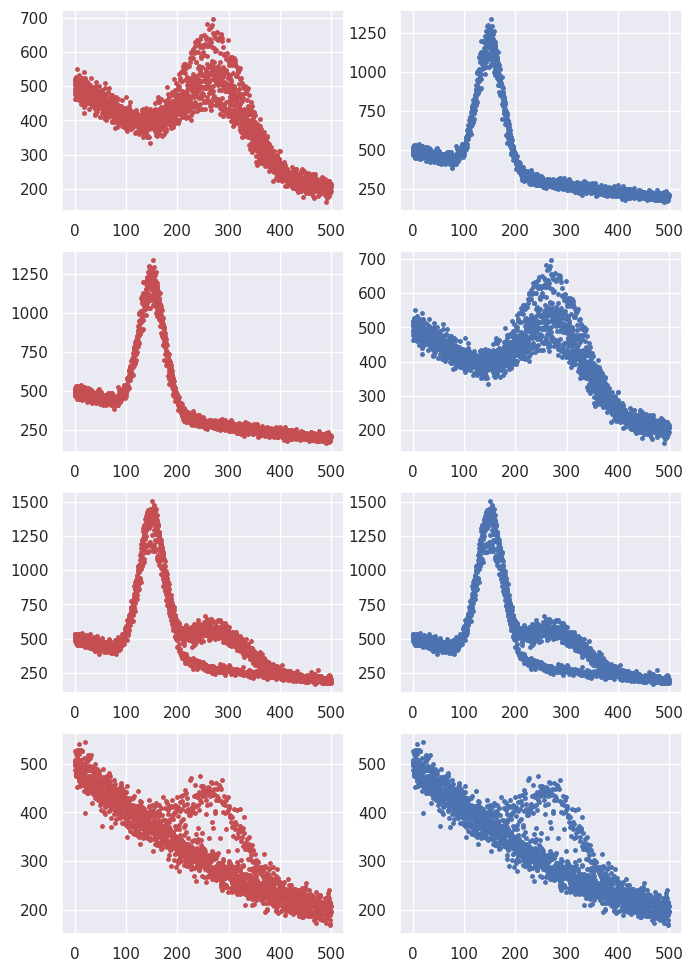

In [98]:
labels1, labels2 = compare_clusters(spectra_data, 4, 2)
fig, ax = plt.subplots(4, 2, figsize=(8, 12))
for i in range(4):
    sel1 = np.where(labels1 == i)[0]
    sel2 = np.where(labels2 == i)[0]
    for j in range(4):
        ax[i, 0].plot(spectra_data.iloc[sel1[j]], 'r.', ms=5)
        ax[i, 1].plot(spectra_data.iloc[sel2[j]], 'b.', ms=5)

Analyzing your results above, comment in the empty markdown cell below on how the full vs reduced clusters compare and whether there is any potential advantage to clustering in reduced dimensions.

<img src="https://raw.githubusercontent.com/illinois-mlp/MachineLearningForPhysics/main/img/AnsStart.svg" width=200 align=left></img><br>

The full and reduced clusters look effectively the same (asside from order). It therefore seems beneficial to use the reduced data since it does not result in different results at all but uses fewer dimensions.

<img src="https://raw.githubusercontent.com/illinois-mlp/MachineLearningForPhysics/main/img/AnsEnd.svg" width=200 align=left></img><br>

## <span style="color:Orange">Acknowledgments</span>

* Initial version: Mark Neubauer

© Copyright 2025